### Learning Goals:
The first goal for this practice
set is to dive deeper into understanding action potentials, using quantitative models developed by
Hodgkin and Huxley; these pioneering models are widely used in the fields of bioengineering and
neuroscience, and have formed the basis for ongoing research in computational neuroscience. Here, we
look to provide you with an opportunity to explore quantitative modeling of ion contributions to neuronal
action potentials, and examine the role of ion channel blockers through parameter estimation in Python.
The second goal of this practice set is to introduce two sets of techniques, signal processing and machine
learning, which have been instrumental in allowing us to operate around real world conditions. First, I
will see how signal processing techniques are used to represent and condition signals. In tandem, I will
use this with supervised learning to build a seizure detector around neurophysiological data from a human
subject with epilepsy.

### Reference Papers:
 The following reference papers may be helpful in providing additional context and
specific experimental details:
1. Hodgkin and Huxley “[A quantitative description of membrane current and its application to
conduction and excitation in nerve](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/pdf/jphysiol01442-0106.pdf)”
2. Hodgkin and Huxley “[The components of membrane conductance in the giant axon of Loligo](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392209/pdf/jphysiol01447-0106.pdf)”

 An Exploration of the Hodgkin-Huxley Model

A classic in mathematical biology, the Hodgkin Huxley model remains fundamental to understanding the generation of action potentials and the conduction of signals along neurons. In this assignment, we will be A) implementing the Hodgkin Huxley model in Python and understanding its physiological relevance, B) using parameter estimation on data from one of the original Hodgkin-Huxley papers, and C) combining the Hodgkin Huxley model and parameter estimation to infer the mode of action of a pharmacological agent based on the shape of the action potential.

A useful reference for this assignment is the 1952 J. Physiology paper by Hodgkin and Huxley (“A quantitative description of membrane current and its application to conduction and excitation in nerve”, PubMed ID: 12991237), and is provided to you in the Canvas folder containing relevant files for this assignment. A

Note that there are four differential equations and six equations for the various rate constants α and β.

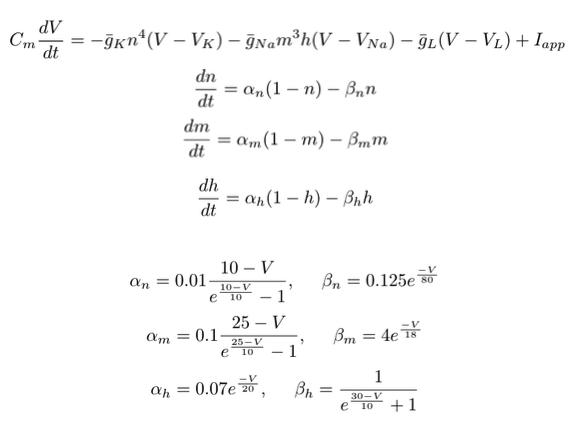

$C_m$ = 1 $uF/cm^2$.  $\bar g_K$ , $\bar g_{Na}$, and $\bar g_L$ are the constant components of the potassium, sodium, and leak current conductances and have values 36, 120, and 0.3 $mS/cm^2$, respectively. $V_K$, $V_{Na}$, and $V_L$ have values of  -12, 115, and 10.6 mV, respectively.

In [ ]:
import os
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.io import loadmat
import scipy.signal
from scipy.io import loadmat

from scipy.stats import skew, kurtosis
from sklearn import preprocessing, svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#### Calculating α, β, n, m, h.

The function evaluateAlphaBeta below takes in one input (the value of V) and outputs the values for the
three α and three β equations. Deriving the equations for n, m, and h, assuming the system is at steady state $\frac{dn}{dt}$, $\frac{dm}{dt}$, and $\frac{dh}{dt}$ = 0 and V = 0 (which occurs when the cell is at its resting membrane potential). Then, completing the function evaluateNMH below that calculates n, m, and h based on the provided $\alpha$ and $\beta$ rate constant inputs and your derived equations. Using the evaluateAlphaBeta and evaluateNMH functions, calculate n, m, and h when V = 0. These will serve as initial values for the simulation of the
Hodgkin Huxley differential equations in subsequent parts.

In [ ]:
#UNITS: all units the same when inputting into eqs (conductance in mS/cm2,
# voltage in mV, current in uA/cm2, time in ms)

def evaluateAlphaBeta(V):
    an = 0.01*(10-V)/(np.exp((10-V)/10)-1)
    am = 0.1*(25-V)/(np.exp((25-V)/10)-1)
    ah = 0.07*np.exp(-V/20)

    Bn = 0.125*np.exp(-V/80)
    Bm = 4*np.exp(-V/18)
    Bh = 1/(np.exp((30-V)/10) + 1)

    return an, am, ah, Bn, Bm, Bh

def evaluateNMH(an, am, ah, Bn, Bm, Bh):
    n = an/(an+Bn)
    m = am/(am+Bm)
    h = ah/(ah+Bh)
    return n, m, h

V= 0
an, am, ah, Bn, Bm, Bh = evaluateAlphaBeta(V)
eval1 =  evaluateNMH(an, am, ah, Bn, Bm, Bh)
print(an, am, ah, Bn, Bm, Bh)
print(eval1)


0.05819767068693265 0.22356372458463003 0.07 0.125 4.0 0.04742587317756678
(0.3176769140606974, 0.05293248525724958, 0.5961207535084603)


In [ ]:
#  checks
print("an0, am0, ah0, Bn0, Bm0, Bh0:")
print(0.05819767068693265, 0.22356372458463003, 0.07, 0.125, 4.0, 0.04742587317756678)
print("n0,m0,h0:")
print(0.3176769140606974, 0.05293248525724958, 0.5961207535084603)

Confirm that your above output is similar, if not the same, to the expected output:
an0, am0, ah0, Bn0, Bm0, Bh0:
0.05819767068693265 0.22356372458463003 0.07 0.125 4.0 0.04742587317756678
n0,m0,h0:
0.3176769140606974 0.05293248525724958 0.5961207535084603


#### Simulating an action-potential with the Hodgkin-Huxley Model

 Simulating an action potential using the HHmodel function. This function takes in as input t (a time vector to simulate the action potential over) and initial conditions for V, n, m, and h, and Iapp (the applied current). Creating system of ODEs describing the Hodgkin-Huxley model. Use odeint to approximate values for V, n, m, and h for 0 - 20 ms in at least 200 steps. Assumption Iapp = 0 for this part of the problem and use the initial values for n, m, and h that you found in part A. Physiologically the resting membrane potential of a neuron is about -70mV but for the purposes of this porject, going to set the initial value for V to 8 mV. Providing two plots: one figure for V(t) and one figure for n(t), m(t), and h(t) all in the same plot.


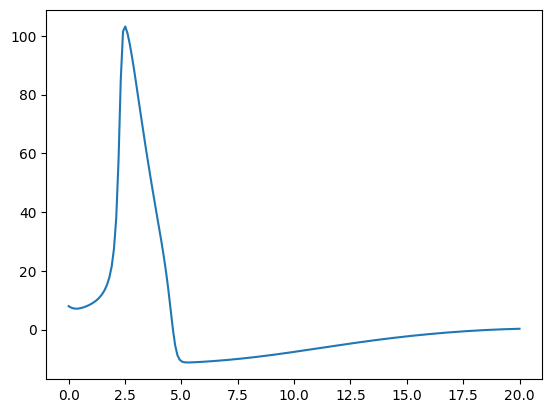

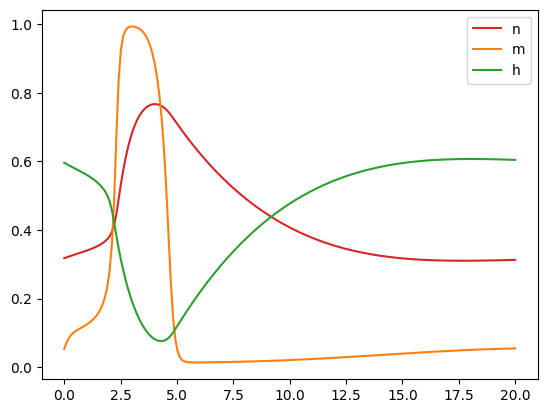

In [ ]:
#UNITS: all units the same when inputting into eqs (conductance in mS/cm2,
# voltage in mV, current in uA/cm2, time in ms)


def HHmodel(t, V0, n0, m0, h0, Iapp = 0):
    Cm = 1
    gK = 36
    gNa = 120
    gL = .3
    VK = -12
    VNa = 115
    VL = 10.6
    n, m, h = eval1
    def model(y,t):
        Vout, nout, mout, hout = y
        an, am, ah, Bn, Bm, Bh = evaluateAlphaBeta(Vout)
        dVoutdt = ((-(gK*(nout**4)*(Vout-VK)))+(-(gNa*(mout**3)*hout*(Vout-VNa)))+(-(gL*(Vout-VL)))+Iapp)/Cm
        dnoutdt = an*(1-nout) - (Bn*nout)
        dmoutdt = am*(1-mout) - (Bm*mout)
        dhoutdt = ah*(1-hout) - (Bh*hout)
        dydt = [dVoutdt, dnoutdt, dmoutdt, dhoutdt]
        return dydt

    y0 = [V0, n0, m0, h0]
    sol = odeint(model, y0, t)
    [Vout, nout, mout, hout]  = sol[:,0] , sol[:,1] , sol[:,2] , sol[:,3]
    return Vout, nout, mout, hout

V0 = 8
t = np.linspace(0,20, 200)
n0, m0, h0 = eval1
Test = HHmodel(t, V0, n0, m0, h0, Iapp = 0)
V, n, m, h = Test
plt.figure(1)
plt.plot(t,V)
plt.figure(2)
plt.plot(t, n, 'tab:red')
plt.plot(t, m, 'tab:orange')
plt.plot(t, h, 'tab:green')
plt.legend(("n", "m", "h"))



```
# This is formatted as code
```

#### Plotting sodium and potassium conductance

 Takes the output and calculates and plots the sodium and potassium conductance over time.

(Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Conductance (mS/cm^2)'),
 <matplotlib.legend.Legend at 0x7f91e8e577c0>)

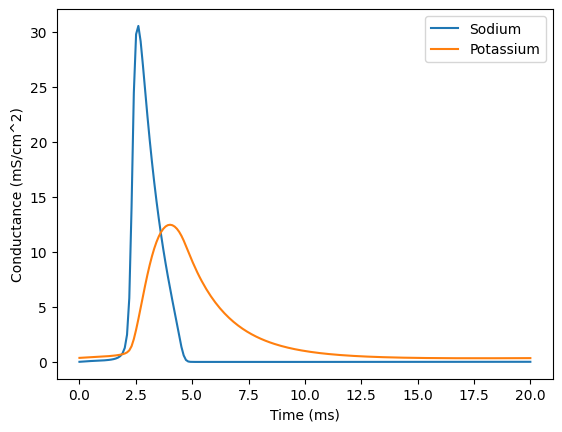

In [ ]:
gK = 36
VK = -12
gNa = 120
VNa = 115

KCond = gK*n**4
NaCond = gNa*m**3*h

plt.plot(t,NaCond), plt.plot(t,KCond)
plt.xlabel("Time (ms)"), plt.ylabel("Conductance (mS/cm^2)"), plt.legend(("Sodium","Potassium"))

#### Observing an action-potential at non-resting potential.

plotting the time-course curves for V, n, m, h, and sodium and potassium conductance when the initial voltage is 50mV (3 plots: one figure for V, one figure for n, m, and h, and one figure for sodium and potassium). Assuming the initial values for n, m, h, and Iapp are the same as before and keeping the time vector consistent.

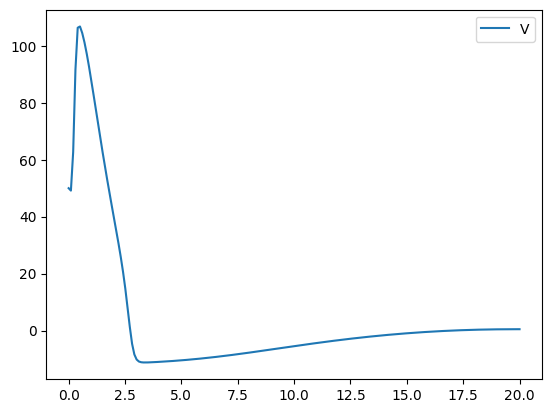

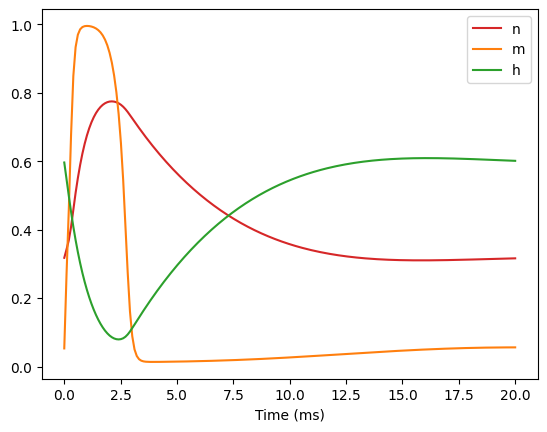

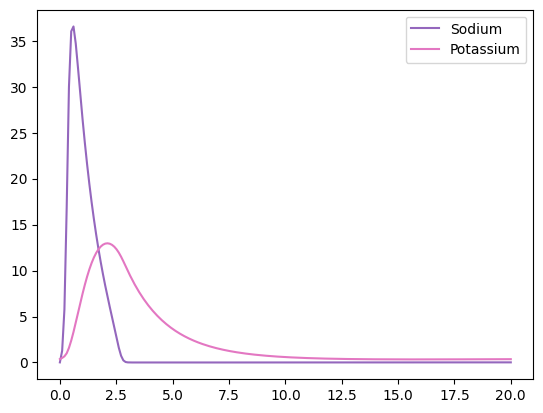

In [ ]:
#UNITS: all units the same when inputting into eqs (conductance in mS/cm2,
# voltage in mV, current in uA/cm2, time in ms)

V0 = 50
t = np.linspace(0,20, 200)
n0, m0, h0 = eval1
Test = HHmodel(t, V0, n0, m0, h0, Iapp = 0)
V, n, m, h = Test
KCond = gK*n**4
NaCond = gNa*m**3*h

plt.figure(1)
plt.plot(t,V)
plt.legend(("V"))
plt.figure(2)
plt.xlabel("Time (ms)"),
plt.plot(t, n, 'tab:red')
plt.plot(t, m, 'tab:orange')
plt.plot(t, h, 'tab:green')
plt.legend(("n", "m", "h"))
plt.figure(3)
plt.plot(t,NaCond, 'tab:purple')
plt.plot(t,KCond, 'tab:pink')
plt.legend(("Sodium","Potassium"))

#### Observing an action-potential when current is applied to the neuron

Using previous code, plotting the time-course curves for V, n, m, h, and sodium and potassium conductance when the initial voltage is 50 mV and 100 $uA/cm^2$ current is applied. Assuming the initial values for n, m, and h are the same as before. Updating time vector to simulate over 50 ms in at least 200 steps.

Text(0.5, 0, 'Time (ms)')

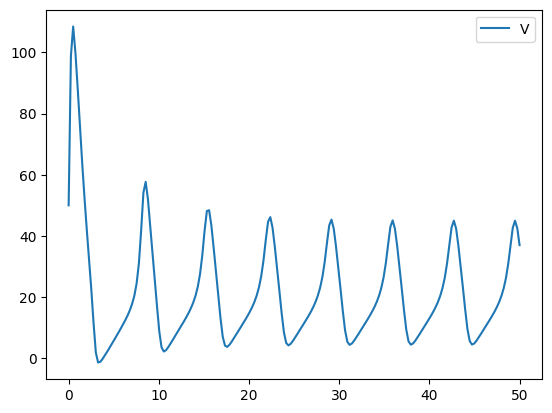

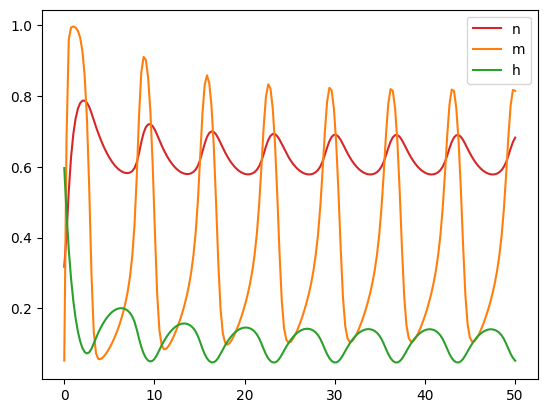

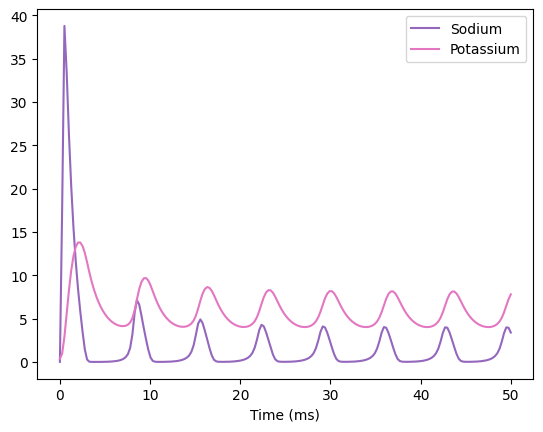

In [ ]:
#UNITS: keep all units the same when inputting into eqs (conductance in mS/cm2,
# voltage in mV, current in uA/cm2, time in ms)
#for the rest of the problem set(q2-4), please adhere to this unit convention as well

V0 = 50
t = np.linspace(0,50, 200)
n0, m0, h0 = eval1
Test = HHmodel(t, V0, n0, m0, h0, Iapp = 100)
V, n, m, h = Test
KCond = gK*n**4
NaCond = gNa*m**3*h
plt.figure(1)
plt.plot(t,V)
plt.legend(("V"))
plt.figure(2)
plt.plot(t, n, 'tab:red')
plt.plot(t, m, 'tab:orange')
plt.plot(t, h, 'tab:green')
plt.legend(("n", "m", "h"))
plt.figure(3)
plt.plot(t,NaCond, 'tab:purple')
plt.plot(t,KCond, 'tab:pink')
plt.legend(("Sodium","Potassium"))
plt.xlabel("Time (ms)")

### End Code ###

##The Hodgkin Huxley Model, Continued



```
# This is formatted as code
```

#### Parameter estimation for potassium conductance

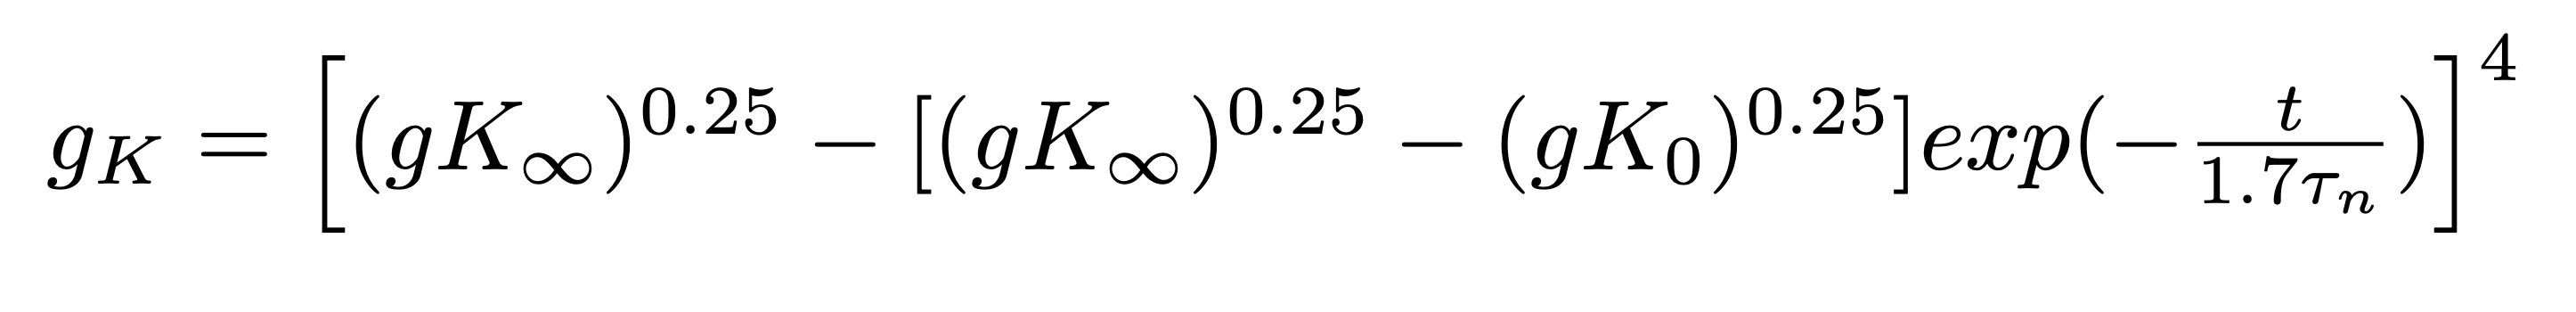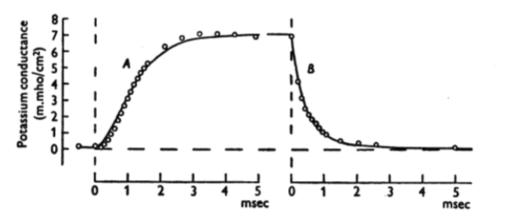

Plotting predicted potassium conductance against the measured data.



In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


(Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Conductance (mS/cm^2)'),
 <matplotlib.legend.Legend at 0x7f91e7b2e3b0>)

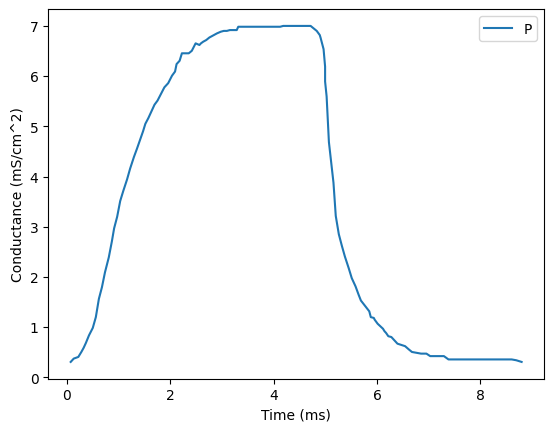

In [ ]:
## File reading

filepath =  "/content/drive/MyDrive/Problem2HHData.mat"
data = loadmat(filepath)

Kt = np.squeeze(data["K_Time"])
KCond = np.squeeze(data["K_Conductance"])

plt.figure(), plt.plot(Kt, KCond)
plt.xlabel("Time (ms)"), plt.ylabel("Conductance (mS/cm^2)"), plt.legend(("Potassium"))

6.983829893241715 0.5029263998058938 0.3162878863753472 0.4269710936849656


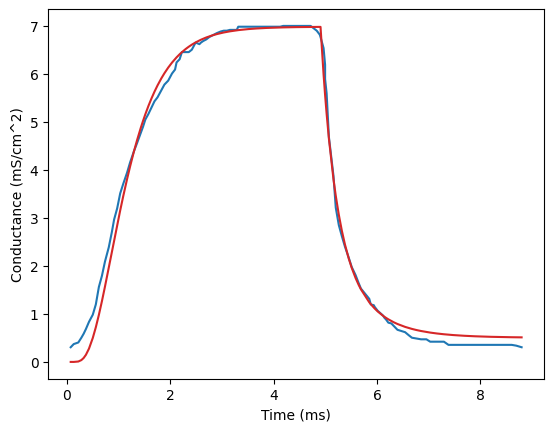

In [ ]:

def func(t, gKinf, gK0, tn25, tn0):

    # defines two sub-equations within "func", one that calculates the conductance during the 25 mV phase
    # and one that calculates the conductance during the 0 mV phase, and concatenates the outputs of these equations
    # together to get the complete conductance curve

    t1 = np.asarray([currt for currt in t if currt < 4.9])
    t2 = np.asarray([currt for currt in t if currt >= 4.9])

    gK1 = (gKinf**0.25 - (gKinf**0.25 - gK0**0.25)*np.exp(-(t1-0.5)/(1.7*tn25)))**4
    gK2 = (gK0**0.25 - (gK0**0.25 - gK1[-1]**0.25)*np.exp(-((t2-t2[0]))/(1.7*tn0)))**4

    gK = np.concatenate((gK1, gK2))

    return gK
gKinf = .1
gK0 = .1
tn25 = .1
tn0 = .1
p0 = [gKinf, gK0, tn25,tn0]
bounds = [(-np.inf,-np.inf,-np.inf,-np.inf),(np.inf,np.inf,np.inf,np.inf)]
t = np.linspace(0,501,20)
popt, pcov = curve_fit(func, Kt, KCond, p0=p0, bounds=bounds)
predicted = func(Kt,popt[0], popt[1], popt[2], popt[3])
plt.plot(Kt, KCond), plt.plot(Kt,predicted, 'tab:red')
plt.xlabel("Time (ms)"), plt.ylabel("Conductance (mS/cm^2)")
print(popt[0], popt[1], popt[2], popt[3])


#### Hodgkin-Huxley Model and Parameter *Estimation*

(Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Voltage (mV)'))

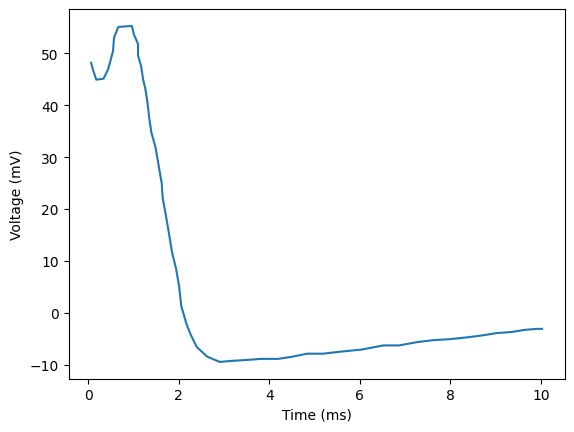

In [ ]:
# Loading in Data from ActionPotential1.mat
filepath = "/content/drive/MyDrive/ActionPotential1.mat"
data = loadmat(filepath)

t1 = np.squeeze(data["ActionPotential1Time"])
A1 = np.squeeze(data["ActionPotential1Voltage"])

plt.figure(), plt.plot(t1, A1)
plt.xlabel("Time (ms)"), plt.ylabel("Voltage (mV)")

In [ ]:
def HHmodel_2c(t, V0, n0, m0, h0, gK, gNa, Iapp = 0):
    Cm = 1
    gL = .3
    VK = -12
    VNa = 115
    VL = 10.6
    n, m, h = eval1
    def model(y,t):
        Vout, nout, mout, hout = y
        an, am, ah, Bn, Bm, Bh = evaluateAlphaBeta(Vout)
        dVoutdt = ((-(gK*(nout**4)*(Vout-VK)))+(-(gNa*(mout**3)*hout*(Vout-VNa)))+(-(gL*(Vout-VL)))+Iapp)/Cm
        dnoutdt = an*(1-nout) - (Bn*nout)
        dmoutdt = am*(1-mout) - (Bm*mout)
        dhoutdt = ah*(1-hout) - (Bh*hout)
        dydt = [dVoutdt, dnoutdt, dmoutdt, dhoutdt]
        return dydt
    y0 = [V0, n0, m0, h0]
    sol = odeint(model, y0, t)
    [Vout, nout, mout, hout]  = sol[:,0] , sol[:,1] , sol[:,2] , sol[:,3]
    return Vout

gK2 = 43.6871587857169 gNa2 = 17.209307880168176


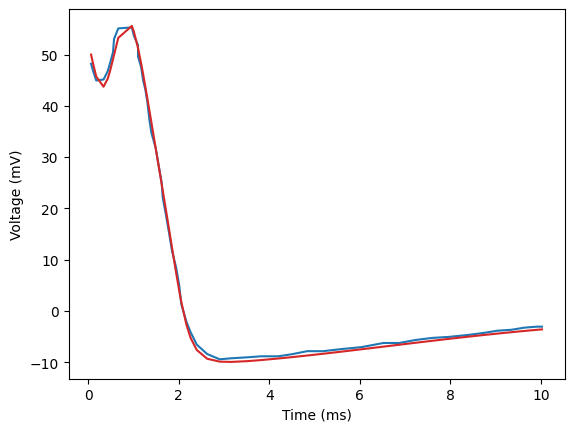

In [ ]:
n0,m0,h0 =  evaluateNMH(an, am, ah, Bn, Bm, Bh)
#p0 = [gK, gNa]
#print(gK, gNa)
def newFunc(t, gK2, gNa2):
  n0,m0,h0 =  evaluateNMH(an, am, ah, Bn, Bm, Bh)
  Vout = HHmodel_2c(t1,V0=50, n0=n0, m0=m0, h0=h0, gK=gK2, gNa=gNa2,Iapp = 0)
  return Vout
#bounds = [(-np.inf,-np.inf),(np.inf, np.inf)]
popt, pcov = curve_fit(newFunc, t1, A1)
predicted = newFunc(t1, popt[0], popt[1])
plt.plot(t1, A1), plt.plot(t1, predicted, 'tab:red')
plt.xlabel("Time (ms)"), plt.ylabel("Voltage (mV)")
print("gK2 =",popt[0],"gNa2 =",popt[1])

(Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Voltage (mV)'))

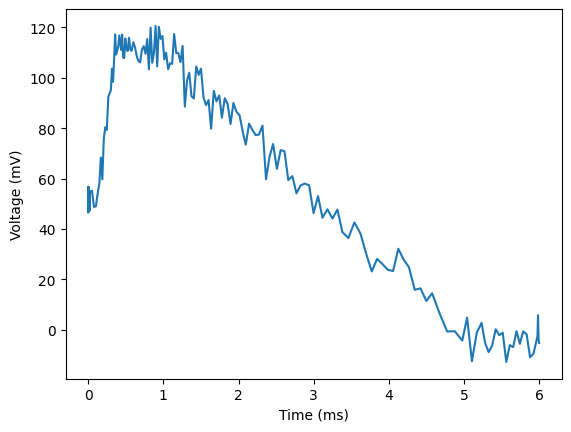

In [ ]:
# Load in Data from ActionPotential2.mat
filepath = "/content/drive/MyDrive/ActionPotential2.mat"

data = loadmat(filepath)
t2 = np.squeeze(data["ActionPotential2Time"])
A2 = np.squeeze(data["ActionPotential2Voltage"])

plt.figure(), plt.plot(t2, A2)
plt.xlabel("Time (ms)"), plt.ylabel("Voltage (mV)")

gK2 = 6.025268521979335 gNa2 = 115.74121871962214


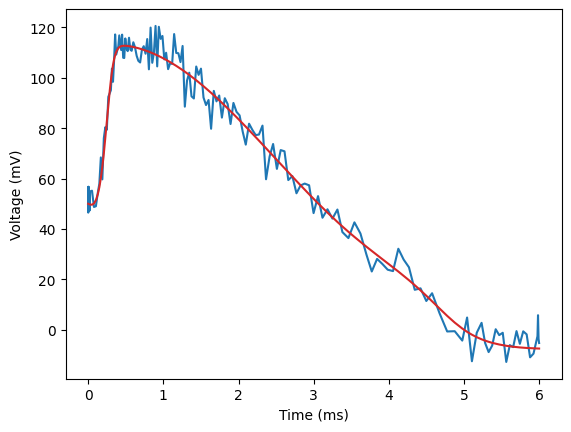

In [ ]:
V0 = 50
n0,m0,h0 =  evaluateNMH(an, am, ah, Bn, Bm, Bh)
def newFunc2(t, gK, gNa):
  n0,m0,h0 =  evaluateNMH(an, am, ah, Bn, Bm, Bh)
  Vout = HHmodel_2c(t2,V0=50, n0=n0, m0=m0, h0=h0, gK=gK, gNa=gNa,Iapp = 0)
  return Vout
popt, pcov = curve_fit(newFunc2, t2, A2)
predicted = newFunc2(t2, popt[0], popt[1])
plt.plot(t2, A2), plt.plot(t2, predicted, 'tab:red')
plt.xlabel("Time (ms)"), plt.ylabel("Voltage (mV)")
print("gK2 =",popt[0],"gNa2 =",popt[1])

##   Spectral analysis for processing physiological signals

In signal processing, we’re interested in how we can transform our measurements into a useful form by
amplifying salient features, attenuating noise, or compressing the signal. In this problem, we will
familiarize ourselves with Fourier analysis. Using Fourier analysis, we represent our signals as a
summation of individual sine and cosine terms, which, when taken together, make up a spectrum of
periodic signals (sinusoids). Fourier analysis is especially useful in dealing with certain types of
physiological signals, like ones commonly encountered in bioengineering and in medicine.

For example, when acquiring a volumetric time series through imaging (e.g. cardiac imaging), our desired
signal mixes and is contaminated with other physiological signals, like respiration and heart beats. I
can isolate specific components of signals systematically by considering their ‘frequency content’. Here, I will deal with idealized signals (signals constructed without noise) to help  appreciate how the tools
we use operate.


#### Constructing Synthetic Signals

I begin by constructing synthetic signals for us to explore. Specifically, we will be looking at a
mixture of sinusoids, a linear chirp, and a square wave. The formulas are listed below in terms of
amplitude (α), phase (ϕ, radians), and frequency (f, Hz).

Let's start by constructing three different signals, a mixed sinusoid, linear chirp, and square wave that I'll analyze later using fourier analysis. The signals are described below:


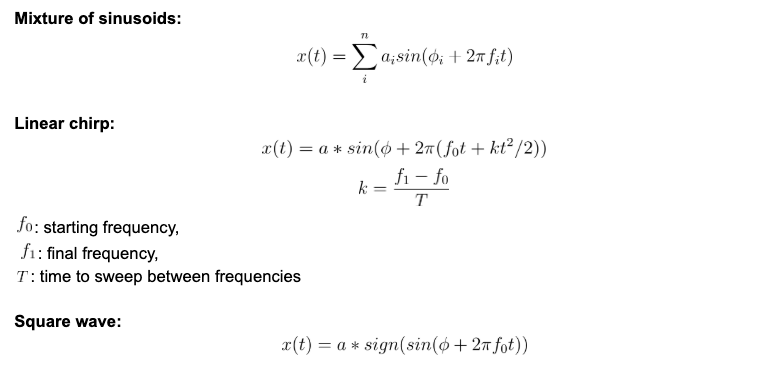


(Text(0.5, 1.0, 'Linear Chirp'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Amplitude'))

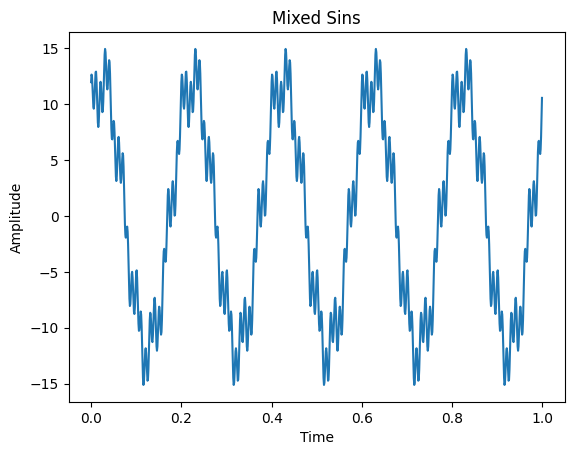

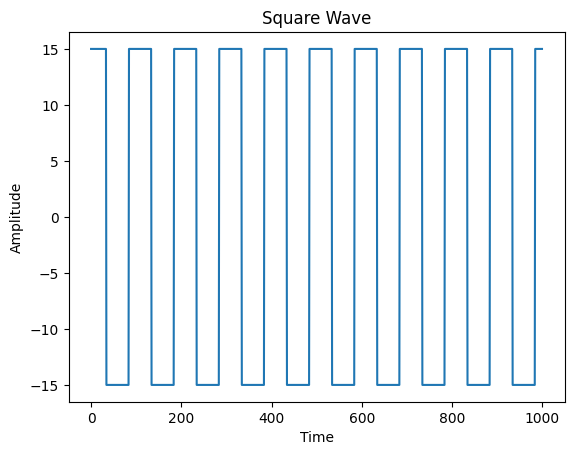

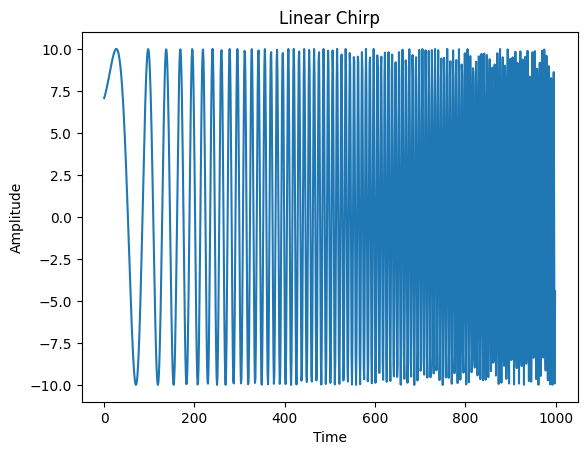

In [ ]:
def mixed_sins(time, amps, freqs, phases):
    mixedSinWave = np.zeros(len(time))
    for i in range(len(amps)):
      mixedSinWave = mixedSinWave + amps[i]*np.sin((phases[i]+(2*np.pi*freqs[i]*time)))
    return mixedSinWave


def linear_chirp(time, amp, f0, f1, T, phase):
    k = (f1-f0)/T
    linearChirp = amp*np.sin(phase+2*np.pi*(f0*time+ k*(time**2)/2))

    return linearChirp


def square_wave(time, amp, freq, phase):

    squareWave = amp*np.sign(np.sin(phase+2*np.pi*freq*time))

    return squareWave



# sampling parameters
fs = 1000; # Hz sampling frequency at 1000 Hz to ensure full spectral coverage;
Ts = 1.0/fs # sample period
tf = 1.  # time span

# time vector
time = np.linspace(0.0,tf-Ts,fs)


mixedSins = mixed_sins(time, [12, 2, 2], [5, 30, 100], [np.pi/4, np.pi/3, np.pi/3])
squareWave = square_wave(time, 15, 10, np.pi/3)
linearChirp = linear_chirp(time, 10, 2, 100, 0.5, np.pi/4)

plt.figure(1), plt.plot(time, mixedSins)
plt.title("Mixed Sins"), plt.xlabel("Time"), plt.ylabel("Amplitude")

plt.figure(2), plt.plot(squareWave)
plt.title("Square Wave"), plt.xlabel("Time"), plt.ylabel("Amplitude")

plt.figure(3), plt.plot(linearChirp)
plt.title("Linear Chirp"), plt.xlabel("Time"), plt.ylabel("Amplitude")

#### Fourier Transforms

I can represent any signal as a summation of sinusoids with varying amplitudes. Finding the amplitude (relative presence) and phase (how sinusoids line up) of these sinusoids requires the Fourier
transform, which has a continuous frequency formulation as shown. When dealing with Fourier
transforms, most often see our sinusoids represented as a complex exponential using [Euler's](https://en.wikipedia.org/wiki/Euler%27s_formula) formula.

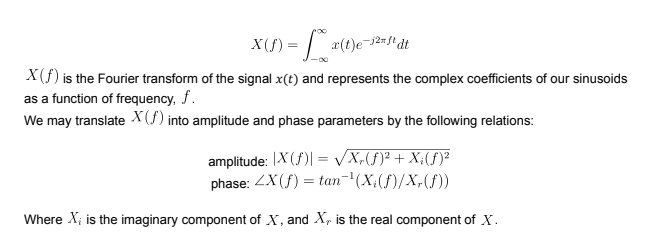

Having constructed our own signals, I am ready to analyze our signals in the frequency domain using Fourier analysis


In [ ]:
def executeFFT(signal, timestep):
    raw_data_fft= np.fft.fft(signal, norm = "ortho")
    freqs = np.abs(np.fft.fftfreq(signal.size, timestep))
    amplitude = np.abs(raw_data_fft)
    return freqs, amplitude

(<Figure size 640x480 with 1 Axes>,
 (0.0, 200.0),
 Text(0.5, 1.0, 'Linear Chirp'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Amplitude (AU)'))

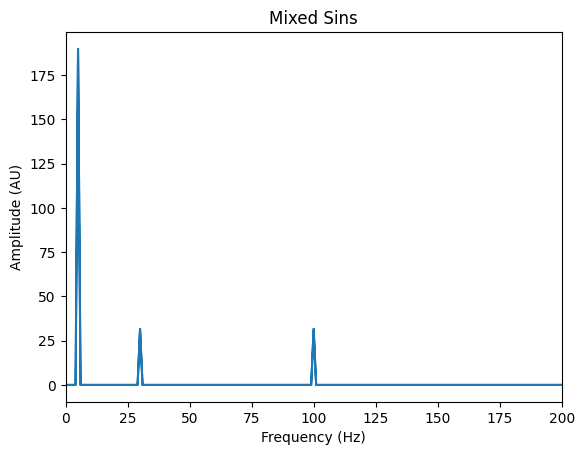

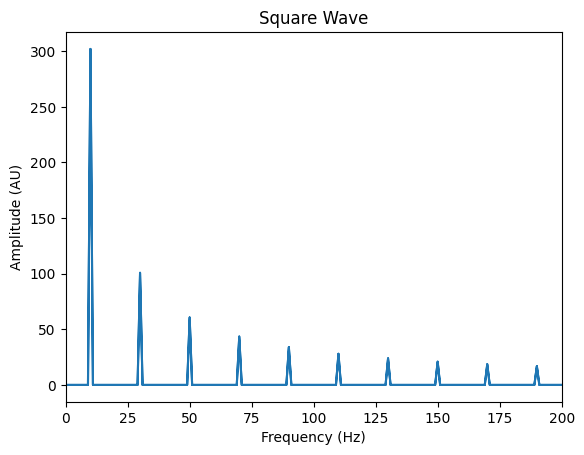

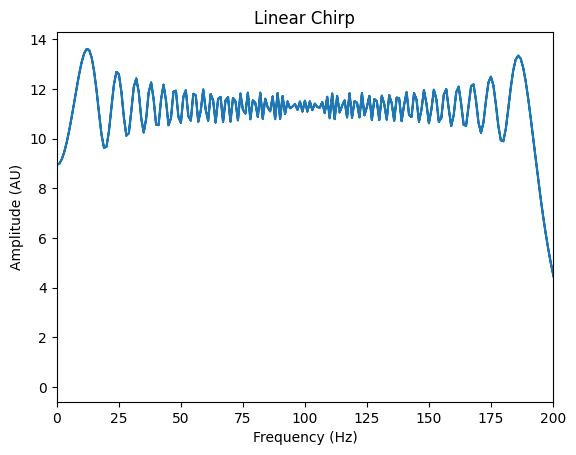

In [ ]:
# Computing the FFT of each signal

freqs, amplitude = executeFFT(mixedSins, Ts)
plt.figure(), plt.plot(freqs, amplitude), plt.xlim([0, 200]), plt.title("Mixed Sins"), plt.xlabel("Frequency (Hz)"), plt.ylabel("Amplitude (AU)")

freqs, amplitude = executeFFT(squareWave, Ts)
plt.figure(), plt.plot(freqs, amplitude), plt.xlim([0, 200]), plt.title("Square Wave"), plt.xlabel("Frequency (Hz)"), plt.ylabel("Amplitude (AU)")

freqs, amplitude = executeFFT(linearChirp, Ts)
plt.figure(), plt.plot(freqs, amplitude), plt.xlim([0, 200]), plt.title("Linear Chirp"), plt.xlabel("Frequency (Hz)"), plt.ylabel("Amplitude (AU)")

## Detecting seizures from intracranial EEG: Kaggle challenge

Using our signal-processing tools towards the Kaggle seizure-detection challenge. We’ll be
examining intracranial EEG recordings from a single subject with epilepsy. The objective is to design a
supervised algorithm, as we defined in class, that can discern whether a seizure is occurring based on
features from the recorded signals. Read the description of this ‘challenge’ at
https://www.kaggle.com/c/seizure-detection (see Overview/Description).

I will first review how I will build and evaluate our classifier algorithm.

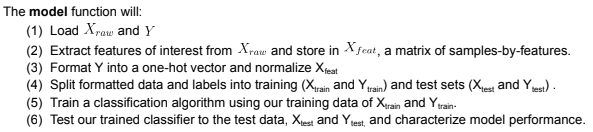

In [ ]:
datapath = "/content/drive/MyDrive/small_data.mat"
data = loadmat(datapath)
X_example = np.asarray(data['X_raw'])
Y_example = np.asarray(data['Y'])

#print shape of the data matrix
print("X_example shape =", np.shape(X_example))
print("Y_example shape =", np.shape(Y_example))


X_example shape = (640, 400)
Y_example shape = (640, 1)


#### Working with examples of ictal and inter-ictal samples

 Plotting an example of an ictal sample and an inter-ictal sample.

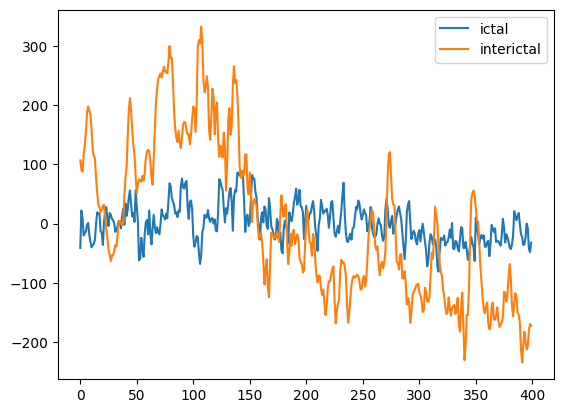

In [ ]:
ictalInd = 16
interictalInd = - 50

plt.plot((X_example[ictalInd]))
plt.plot((X_example[interictalInd]))
plt.legend(("ictal","interictal"))


**Generating SVM**  

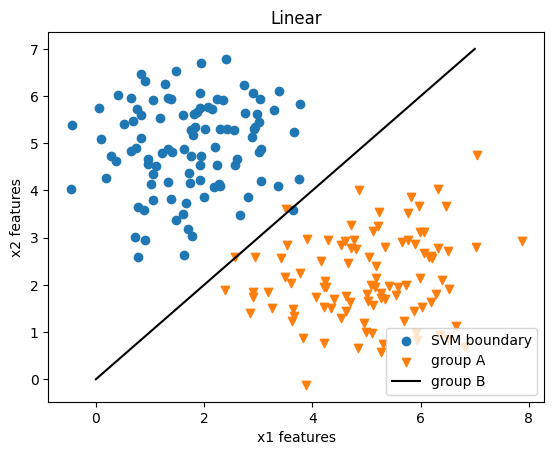

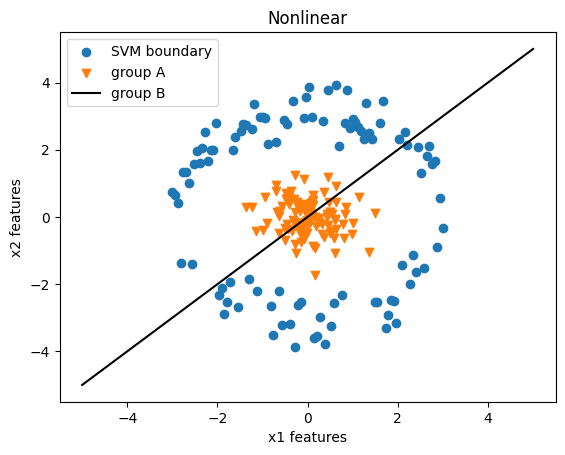

In [ ]:
n = 100

# generating data for linearly separable case
linear_A_x1 = 2 + np.random.randn(n)
linear_A_x2 = 5 + np.random.randn(n)
linear_B_x1 = 5 + np.random.randn(n)
linear_B_x2 = 2 + np.random.randn(n)

# making line representing SVM decision boundary
linear_line_x1x2 = np.linspace(0,7,n)

# plotting data for linearly separable case
plt.scatter(linear_A_x1, linear_A_x2, marker = 'o')
plt.scatter(linear_B_x1, linear_B_x2, marker = 'v')
plt.plot(linear_line_x1x2,linear_line_x1x2,'k')
plt.legend(['SVM boundary','group A','group B'])
plt.title('Linear')
plt.xlabel('x1 features')
plt.ylabel('x2 features')
plt.show()

# generating data for nonlinear case
nonlinear_A_x1 = np.linspace(-3,3,n)
nonlinear_A_x2 = np.sign(np.random.randn(n)) * np.sqrt(np.abs(9 - nonlinear_A_x1**2)) + .5*np.random.randn(n)
nonlinear_B_x1 = 0 + .5*np.random.randn(n)
nonlinear_B_x2 = 0 + .5*np.random.randn(n)


# making line representing SVM decision boundary
nonlinear_line_x1x2 = np.linspace(-5,5,n)

# plotting data for linearly separable case
plt.scatter(nonlinear_A_x1, nonlinear_A_x2, marker = 'o')
plt.scatter(nonlinear_B_x1, nonlinear_B_x2, marker = 'v')
plt.plot(nonlinear_line_x1x2, nonlinear_line_x1x2,'k')
plt.legend(['SVM boundary','group A','group B'])
plt.title('Nonlinear')
plt.xlabel('x1 features')
plt.ylabel('x2 features')
plt.show()

#### Calculating Spectral Features

In [ ]:

def spectralFeatures(X_raw):

    fs = 400 #sampling frequency
    X_raw_data_fft= np.fft.fft(X_raw, norm = "ortho")
    amplitude = np.abs(X_raw_data_fft)
    power = np.abs(X_raw_data_fft)**2
    timestep = 1/fs
    freqs = np.abs(np.fft.fftfreq(X_raw.size, timestep))

    freq_bands = [[0,3], [4,7], [8,12], [13,30], [31,70], [71,180]]

    ### calculating the average power in each frequency band
    X_spectral_feat = np.zeros((X_raw.shape[0], len(freq_bands)))
    print(X_spectral_feat.shape)
    col = 0
    for i in freq_bands:
      start, stop = i
      Average = np.mean(power[:,start:stop], axis = 1)
      X_spectral_feat[:, col] += Average
      col +=1
    return X_spectral_feat

#### Building My Model


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


def model(dataset_small = True):

    if dataset_small:
        data = loadmat("/content/drive/MyDrive/small_data.mat")
    else:
        data = loadmat("/content/drive/MyDrive/full_data.mat")
    X_raw = np.asarray(data['X_raw'])
    Y = np.asarray(data['Y'])

    X_feat = spectralFeatures(X_raw)




    Y = (Y == 'ictal').astype(int)
    scaler = StandardScaler()
    X_feat = scaler.fit_transform(X_feat)

    #  - split the data into training and test sets, using a 0.3 test_size
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_feat, Y, test_size=0.3, shuffle = True)
    print(X_test.shape, y_test.shape)

    #  - define a linear SVM and train it on training data
    #  - see documentation for svm.SVC
        svmModel = svm.SVC(kernel = 'linear')
    svmModel.fit(X_train, y_train)

    y_pred = svmModel.predict(X_test)

    y_score = svmModel.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_score)
    plt.plot(fpr,tpr)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    AUC = metrics.auc(fpr, tpr)

    print("AUC:", AUC)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Run the cells below to run your model (make sure to set the dataset variable), it may take 10-20 minutes to complete on the large dataset.

(640, 6)
(192, 6) (192, 1)
Accuracy: 0.9114583333333334
AUC: 0.919262072707542


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


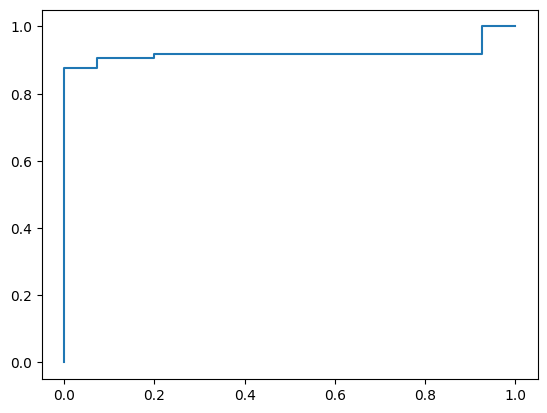

In [ ]:
model(dataset_small=True)

(48752, 6)
(14626, 6) (14626, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9347053192944073
AUC: 0.680708474802474


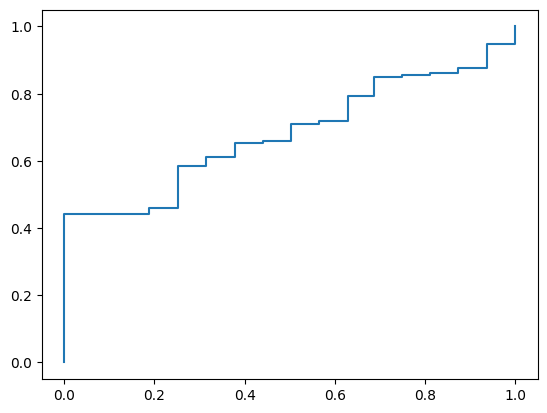

In [ ]:
model(dataset_small=False)